# Importing Libraries

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Loading and Exploring Dataset

In [2]:
df = pd.read_csv("D:\internships\devtern\Spam Detection\spam_ham_dataset.csv")
df.head()


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


# Visualization of dataset distribution 

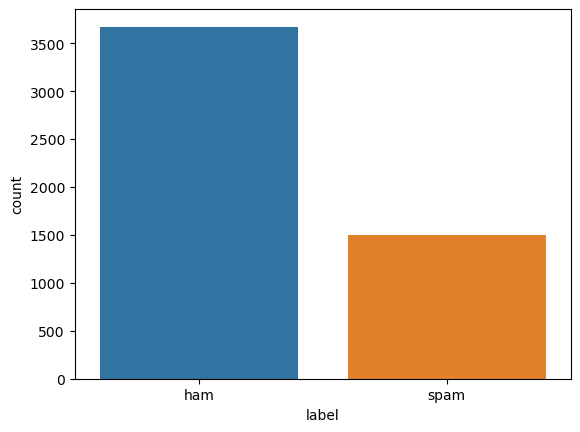

In [3]:
sns.countplot(x='label', data=df)
plt.show()


# Balancing the Dataset

In [4]:
ham_msg = df[df.label_num == 0]
spam_msg = df[df.label_num == 1]
ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)

# Visualizing Balanced Dataset

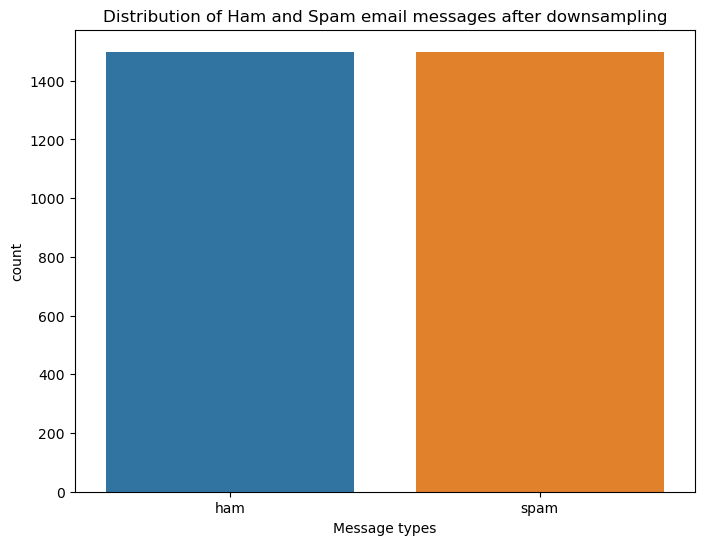

In [10]:
balanced_data = pd.concat([ham_msg, spam_msg], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='label')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')
plt.show()


# Text Preprocessing

In [15]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
        word = word.lower()
 
        if word not in stop_words:
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output
balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


# Visualization Using WordCloud

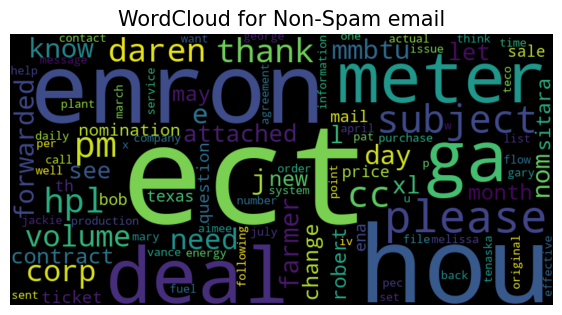

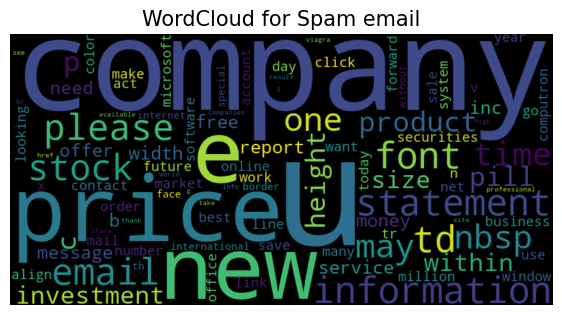

In [17]:
def plot_word_cloud(df, typ):
    sms_corpus = " ".join(df['text'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(sms_corpus)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} email', fontsize=15)
    plt.axis('off')
    plt.show()
 
plot_word_cloud(balanced_data[balanced_data['label_num'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label_num'] == 1], typ='Spam')

# Spliting Of Dataset

In [20]:
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['label_num'],
                                                    test_size = 0.2,
                                                    random_state = 42)

# Tokenization and Padding


In [23]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100  
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len, 
                                padding='post', 
                                truncating='post')
test_sequences = pad_sequences(test_sequences, 
                               maxlen=max_len, 
                               padding='post', 
                               truncating='post')


# Building the LSTM Model

In [31]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           1274912   
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1278625 (4.88 MB)
Trainable params: 1278625 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Model Compilation and Training

In [32]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_sequences, train_Y, epochs=20, batch_size=32, validation_data=(test_sequences, test_Y))



Epoch 1/20


75/75 [==============================] - 13s 92ms/step - loss: 0.6415 - accuracy: 0.5992 - val_loss: 0.3605 - val_accuracy: 0.9633
Epoch 2/20
75/75 [==============================] - 5s 73ms/step - loss: 0.2670 - accuracy: 0.9454 - val_loss: 0.1445 - val_accuracy: 0.9633
Epoch 3/20
75/75 [==============================] - 6s 78ms/step - loss: 0.1328 - accuracy: 0.9679 - val_loss: 0.1271 - val_accuracy: 0.9733
Epoch 4/20
75/75 [==============================] - 6s 75ms/step - loss: 0.1334 - accuracy: 0.9708 - val_loss: 0.1261 - val_accuracy: 0.9717
Epoch 5/20
75/75 [==============================] - 6s 77ms/step - loss: 0.0808 - accuracy: 0.9846 - val_loss: 0.1330 - val_accuracy: 0.9717
Epoch 6/20
75/75 [==============================] - 6s 74ms/step - loss: 0.0707 - accuracy: 0.9867 - val_loss: 0.1386 - val_accuracy: 0.9683
Epoch 7/20
75/75 [==============================] - 6s 75ms/step - loss: 0.0616 - accuracy: 0.9879 - val_loss: 0.0936 - val_accuracy: 0.9800
Epoch 8/2

# Model Evaluation

In [33]:

test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

19/19 [==============================] - 0s 18ms/step - loss: 0.1468 - accuracy: 0.9750
Test Loss: 0.14683550596237183
Test Accuracy: 0.9750000238418579


# Plotting Training and Validation Accuracy

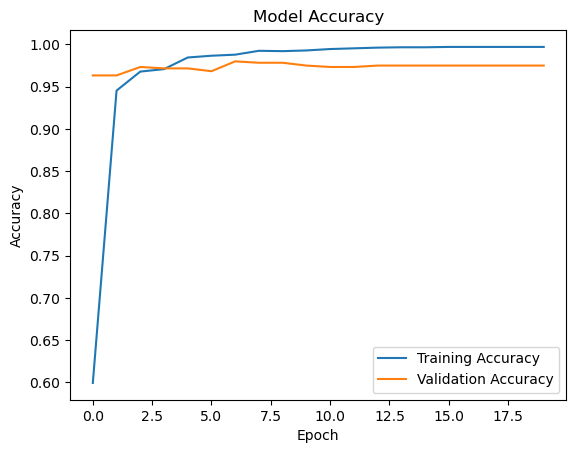

In [34]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()